In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet121, ResNet50, VGG16, EfficientNetB7, InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, LayerNormalization, BatchNormalization, Dropout, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

2024-07-16 08:12:04.406525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 08:12:04.406638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 08:12:04.514887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Directory Paths
DATADIR = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
# TEST_DIR = '/kaggle/input/imagesoasis/Data'
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

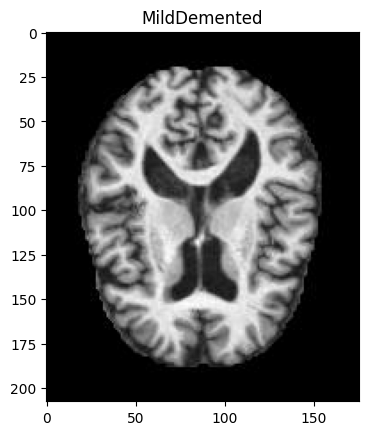

In [3]:
# Display an example image from each class
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.title(category)
        plt.show()
        break
    break

In [4]:
print(img_array.shape)

(208, 176)


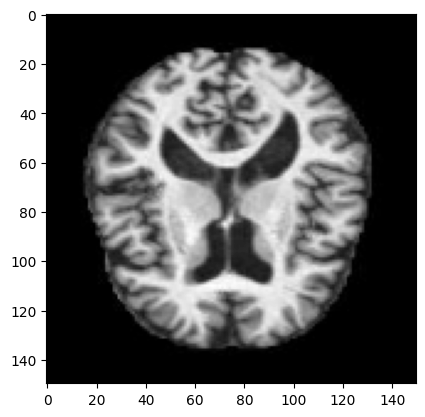

In [5]:
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()


In [6]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

In [7]:
# Shuffling the training data
import random
random.shuffle(training_data)
# random.shuffle(test_data)

In [8]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [10]:
# # Splitting features and labels
# X_train = []
# y_train = []

# for features, labels in training_data:
#     X_train.append(features)
#     y_train.append(labels)

# X_test = []
# y_test = []

# for features, labels in test_data:
#     X_test.append(features)
#     y_test.append(labels)

# X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_train = np.array(y_train)
# X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_test = np.array(y_test)

In [11]:
# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



In [12]:
# Assuming X_train and X_test are already loaded and preprocessed
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [14]:
X_train.shape

(3840, 150, 150, 1)

In [15]:
X_test.shape

(1281, 150, 150, 1)

In [16]:
# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    rotation_range=10, 
    zoom_range=0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=False)

datagen.fit(X_train)


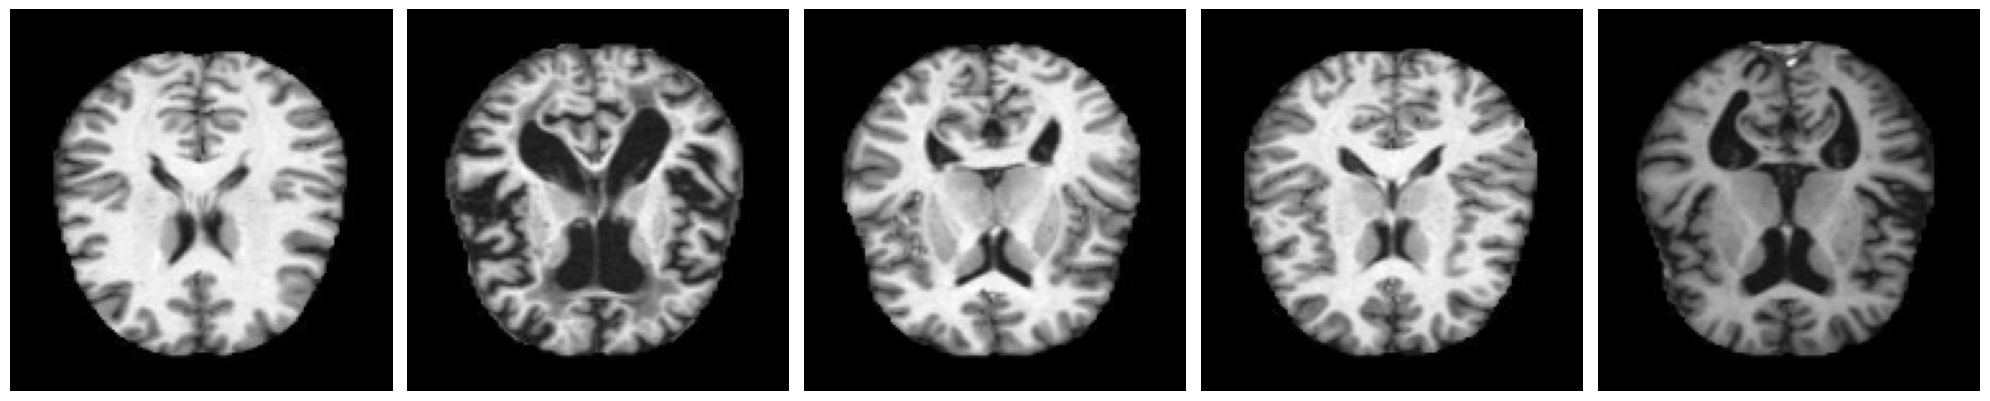

In [17]:
# Visualize original images
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(X_train[:5], axes):
    img = img.reshape(IMG_SIZE, IMG_SIZE)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

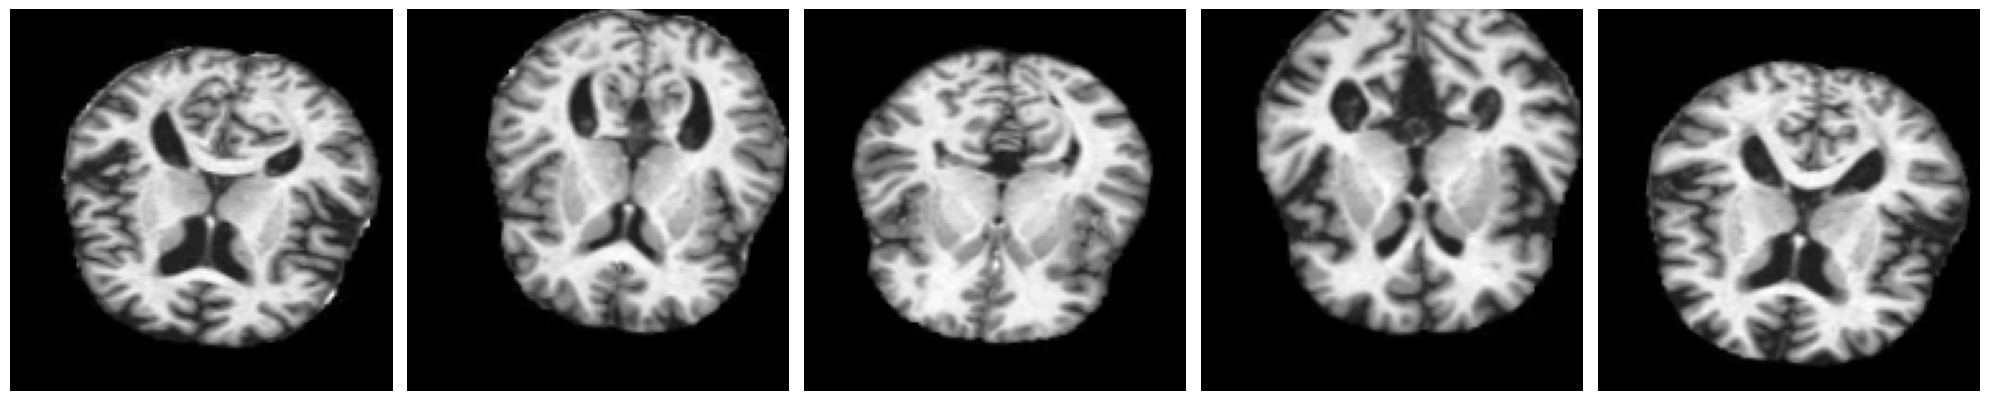

In [18]:
# Visualize augmented images
augmented_images = datagen.flow(X_train, y_train, batch_size=1)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(5):
    augmented_image = next(augmented_images)[0].reshape(IMG_SIZE, IMG_SIZE)
    axes[i].imshow(augmented_image, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [19]:
def proposed_model(input_shape=X_train.shape[1:], num_classes=4):
    model = Sequential()

    # First Layer
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Third Layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # Fourth Layer
    model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # Fifth Layer
    model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # Flattening and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = CategoricalCrossentropy, metrics=['accuracy'])
    return model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [20]:
# model = Sequential()

# # First Layer
# model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=X_train.shape[1:]))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # Second Layer
# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.25))

# # Third Layer
# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.3))

# # Fourth Layer
# model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.3))

# # Fifth Layer
# model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='Same', activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.3))

# # Flattening and Fully Connected Layers
# model.add(Flatten())
# model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(Dropout(0.3))
# model.add(Dense(4, activation='softmax'))

In [21]:
# Compiling the model
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# X_train.shape[1:]

In [23]:
# Function to build models with pre-trained architectures
def pretrained_model(base_model, input_shape=(150, 150, 1), num_classes=4):
    input_tensor = Input(shape=input_shape)
    x = tf.keras.layers.Concatenate()([input_tensor, input_tensor, input_tensor])  # Convert grayscale to 3 channels
    base_model = base_model(include_top=False, weights='imagenet', input_tensor=x)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer='adam', loss = CategoricalCrossentropy, metrics=['accuracy'])
    return model

In [24]:
# Define models
models = {
    'DenseNet121': pretrained_model(DenseNet121),
    'ResNet50': pretrained_model(ResNet50),
    'VGG16': pretrained_model(VGG16),
    'EfficientNetB7': pretrained_model(EfficientNetB7),
    'InceptionV3': pretrained_model(InceptionV3)
}

# Dictionary to store training history
history_dict = {}

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
models['Proposed'].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,619,524 (17.62 MB)

 Trainable params: 4,619,524 (17.62 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Definig some hyperparameters
batch_size =40
epoch = 100

In [27]:
# # Define the seed
# seed = 42

# # Set the random seed
# tf.random.set_seed(seed)

In [28]:
# Train each model with the data generator
for model_name, model in models.items():
    print(f"Training {model_name} Model : ")
    history = model.fit(X_train, y_train, batch_size = 40, validation_data=(X_test, y_test), validation_split = 0.1, epochs = epoch)
    history_dict[model_name] = history.history

Training Proposed Model : 
Epoch 1/100
 2/96 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.3875 - loss: 1.6791  

I0000 00:00:1721117592.028738     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721117592.049406     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4678 - loss: 1.3979

W0000 00:00:1721117598.295803     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.4680 - loss: 1.3965 - val_accuracy: 0.5035 - val_loss: 1.2231
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4973 - loss: 1.1713 - val_accuracy: 0.5035 - val_loss: 1.2004
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4958 - loss: 1.1313 - val_accuracy: 0.5488 - val_loss: 1.1880
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5036 - loss: 1.1121 - val_accuracy: 0.5628 - val_loss: 1.1527
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5367 - loss: 1.0286 - val_accuracy: 0.5769 - val_loss: 0.9645
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5426 - loss: 0.9855 - val_accuracy: 0.5792 - val_loss: 0.9305
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5583 - loss: 0.9582 - val_accuracy: 0.5964 - val_loss: 0.9630
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5784 - loss: 0.9269 - val_accuracy: 0.5839 - val_

W0000 00:00:1721118201.555006     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4553 - loss: 2.0664

W0000 00:00:1721118215.913971     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 273ms/step - accuracy: 0.4562 - loss: 2.0524 - val_accuracy: 0.5714 - val_loss: 0.8973
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5387 - loss: 0.9434 - val_accuracy: 0.6190 - val_loss: 0.8444
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5996 - loss: 0.8747 - val_accuracy: 0.6190 - val_loss: 0.8205
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6133 - loss: 0.8267 - val_accuracy: 0.5730 - val_loss: 0.8383
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6012 - loss: 0.8327 - val_accuracy: 0.6503 - val_loss: 0.8007
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6302 - loss: 0.7896 - val_accuracy: 0.6284 - val_loss: 0.8111
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6267 - loss: 0.7967 - val_accuracy: 0.6479 - val_loss: 0.7637
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6654 - loss: 0.7388 - val_accuracy: 0.6589 - val

W0000 00:00:1721118828.615748     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4343 - loss: 1.2171

W0000 00:00:1721118838.349458     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.4345 - loss: 1.2160 - val_accuracy: 0.5269 - val_loss: 1.0040
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5140 - loss: 1.0122 - val_accuracy: 0.5176 - val_loss: 1.0287
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5073 - loss: 1.0126 - val_accuracy: 0.5277 - val_loss: 1.0071
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5121 - loss: 1.0020 - val_accuracy: 0.5340 - val_loss: 0.9628
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5146 - loss: 0.9891 - val_accuracy: 0.5363 - val_loss: 0.9698
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5234 - loss: 0.9958 - val_accuracy: 0.5379 - val_loss: 0.9666
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5291 - loss: 0.9629 - val_accuracy: 0.5324 - val_loss: 0.9527
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5175 - loss: 0.9698 - val_accuracy: 0.5355 - val

W0000 00:00:1721119534.570890     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4796 - loss: 1.0795

W0000 00:00:1721119543.909408     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - accuracy: 0.4798 - loss: 1.0789 - val_accuracy: 0.5340 - val_loss: 0.9285
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5542 - loss: 0.9473 - val_accuracy: 0.6011 - val_loss: 0.9082
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5767 - loss: 0.9078 - val_accuracy: 0.5902 - val_loss: 0.8668
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5746 - loss: 0.8886 - val_accuracy: 0.6331 - val_loss: 0.8659
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5972 - loss: 0.8570 - val_accuracy: 0.6269 - val_loss: 0.8251
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.6213 - loss: 0.8431 - val_accuracy: 0.6003 - val_loss: 0.8285
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.6491 - loss: 0.7892 - val_accuracy: 0.6112 - val_loss: 0.8254
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.6192 - loss: 0.8131 - val_accuracy

W0000 00:00:1721120817.899302     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4257 - loss: 1.4654

W0000 00:00:1721120848.962622     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 176s 508ms/step - accuracy: 0.4259 - loss: 1.4631 - val_accuracy: 0.5035 - val_loss: 1.0447
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.4868 - loss: 1.0799 - val_accuracy: 0.5035 - val_loss: 1.0335
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.4923 - loss: 1.0534 - val_accuracy: 0.5035 - val_loss: 1.0352
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.4718 - loss: 1.0656 - val_accuracy: 0.5035 - val_loss: 1.0305
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.5041 - loss: 1.0492 - val_accuracy: 0.5035 - val_loss: 1.0282
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.5020 - loss: 1.0427 - val_accuracy: 0.5035 - val_loss: 1.0323
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.4733 - loss: 1.0575 - val_accuracy: 0.5035 - val_loss: 1.0385
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.4962 - loss: 1.0517 - val_accurac

W0000 00:00:1721122769.820112     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4699 - loss: 3.7946

W0000 00:00:1721122779.247268     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.4705 - loss: 3.7581 - val_accuracy: 0.5761 - val_loss: 0.8938
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5673 - loss: 0.9127 - val_accuracy: 0.6034 - val_loss: 0.8475
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5974 - loss: 0.8538 - val_accuracy: 0.6214 - val_loss: 0.8188
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6179 - loss: 0.8049 - val_accuracy: 0.6331 - val_loss: 0.8100
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6401 - loss: 0.7927 - val_accuracy: 0.6136 - val_loss: 0.7882
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6282 - loss: 0.7787 - val_accuracy: 0.6417 - val_loss: 0.7702
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6351 - loss: 0.7568 - val_accuracy: 0.6479 - val_loss: 0.7619
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6532 - loss: 0.7580 - val_accuracy: 0.6425 - val

In [29]:
# Iterate through each model's history
for model_name, history in history_dict.items():
    # Extract history metrics
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    # Calculate final metrics
    Accuracy_Score = round(acc[-1] * 100, 2)
    Validation_Score = round(val_acc[-1] * 100, 2)
    Loss_score = round(loss[-1], 2)
    Validation_loss = round(val_loss[-1], 2)
    
    # Print metrics
    print(f"Model: {model_name}")
    print(f"The Accuracy for the model is: {Accuracy_Score}%")
    print(f"The Validation Accuracy for the model is: {Validation_Score}%")
    print(f"The Loss for the model is: {Loss_score}")
    print(f"The Validation Loss for the model is: {Validation_loss}\n")


Model: Proposed
The Accuracy for the model is: 97.03%
The Validation Accuracy for the model is: 99.14%
The Loss for the model is: 0.27
The Validation Loss for the model is: 0.21

Model: DenseNet121
The Accuracy for the model is: 93.62%
The Validation Accuracy for the model is: 85.56%
The Loss for the model is: 0.17
The Validation Loss for the model is: 0.39

Model: ResNet50
The Accuracy for the model is: 61.43%
The Validation Accuracy for the model is: 60.58%
The Loss for the model is: 0.82
The Validation Loss for the model is: 0.83

Model: VGG16
The Accuracy for the model is: 95.91%
The Validation Accuracy for the model is: 88.6%
The Loss for the model is: 0.13
The Validation Loss for the model is: 0.31

Model: EfficientNetB7
The Accuracy for the model is: 49.87%
The Validation Accuracy for the model is: 50.35%
The Loss for the model is: 1.04
The Validation Loss for the model is: 1.03

Model: InceptionV3
The Accuracy for the model is: 83.88%
The Validation Accuracy for the model is: 7

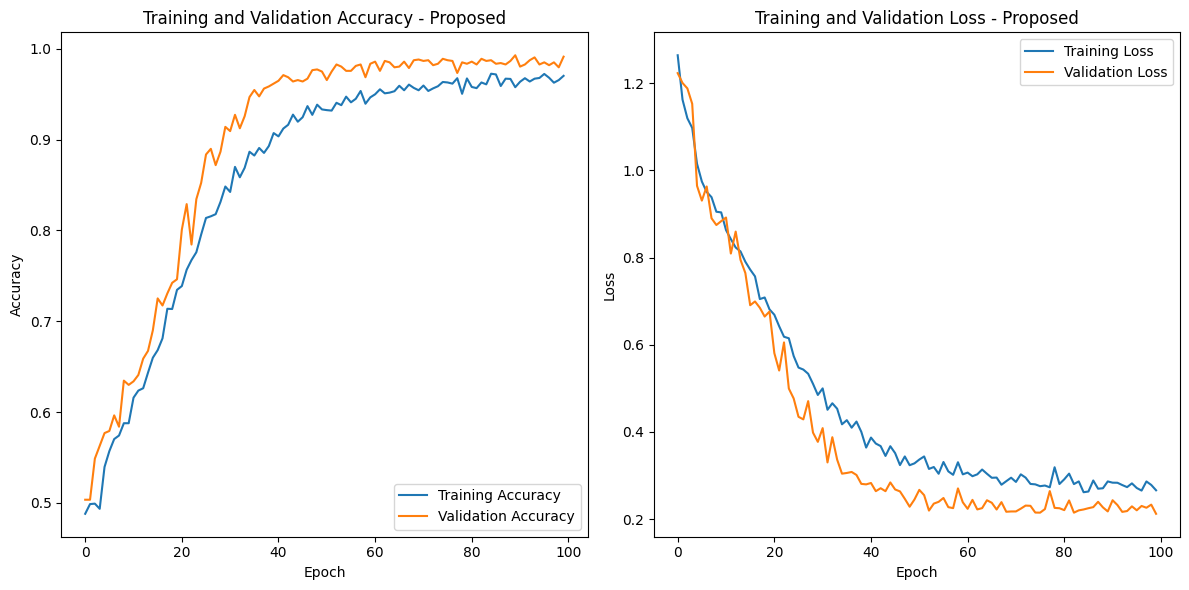

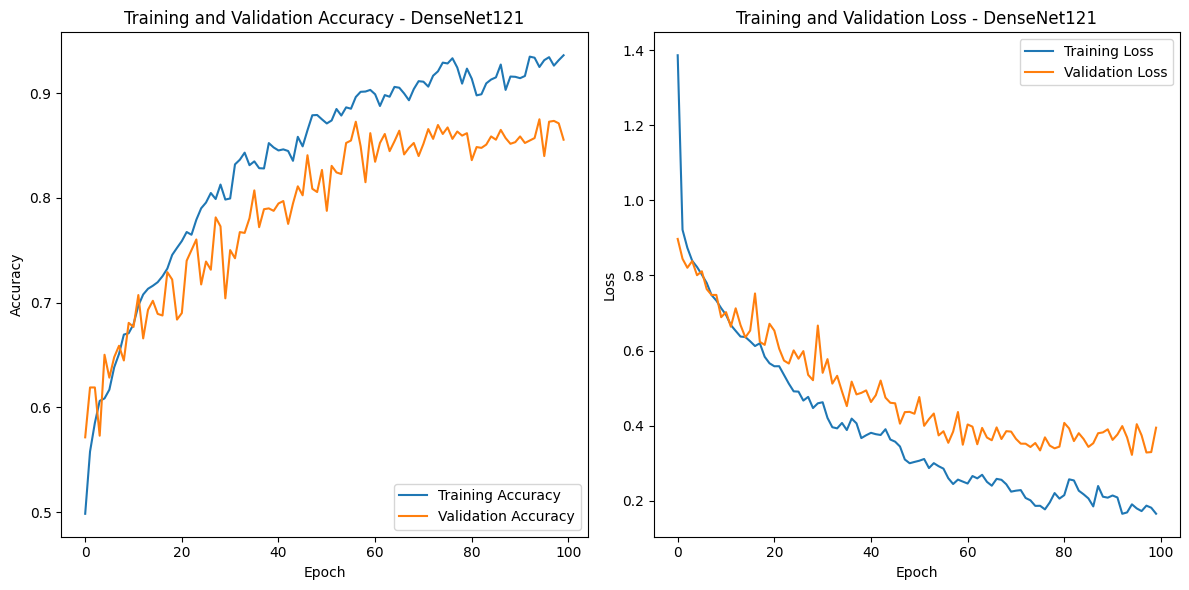

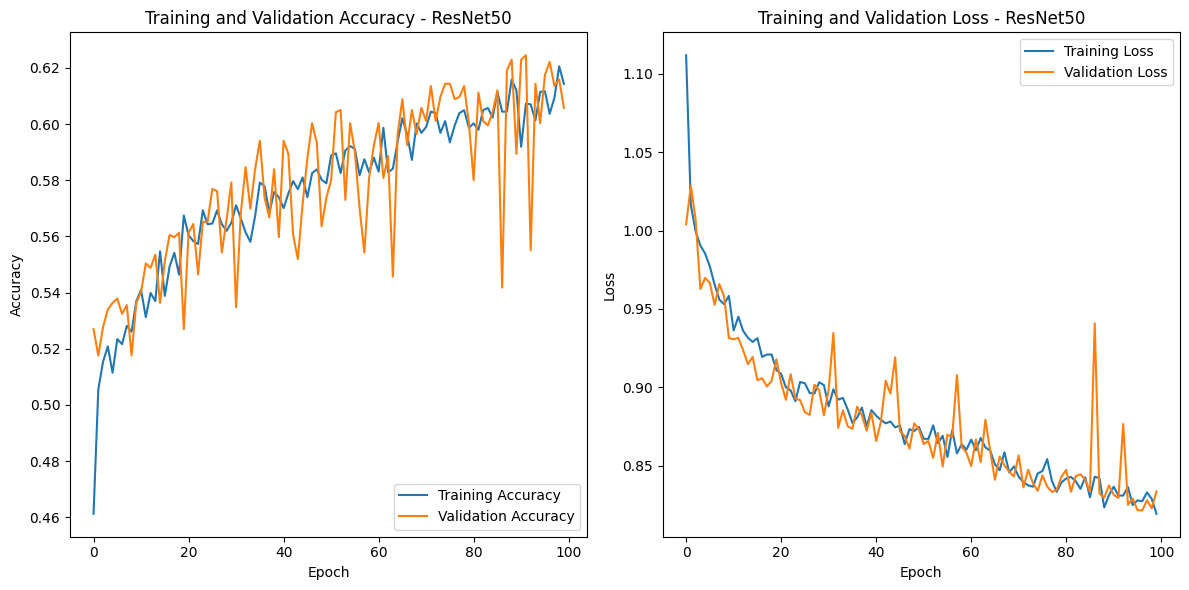

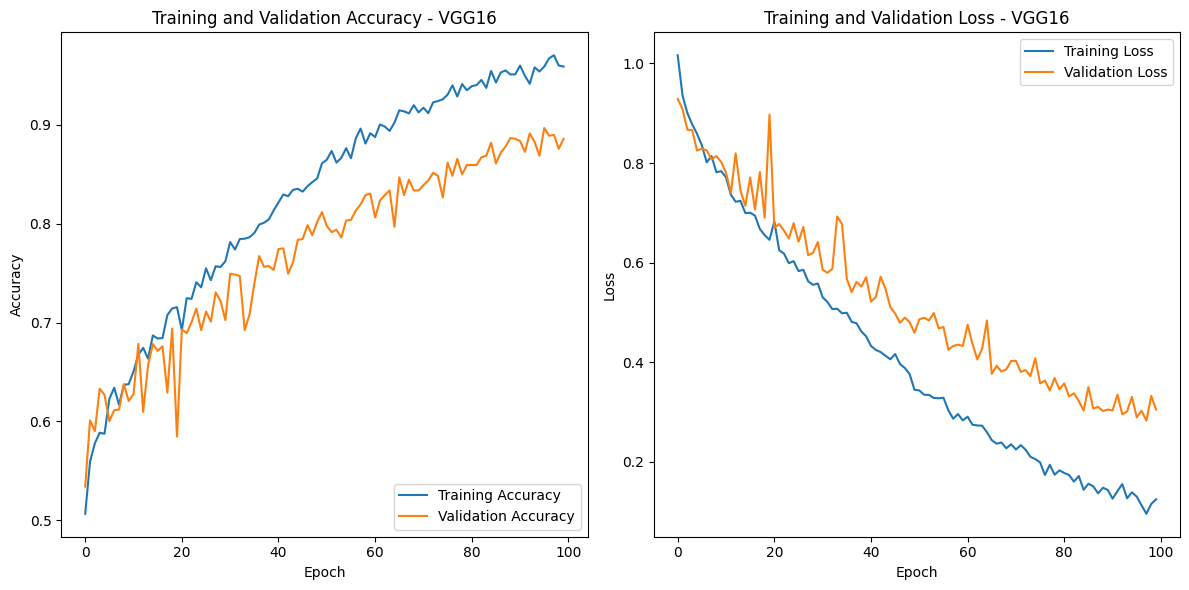

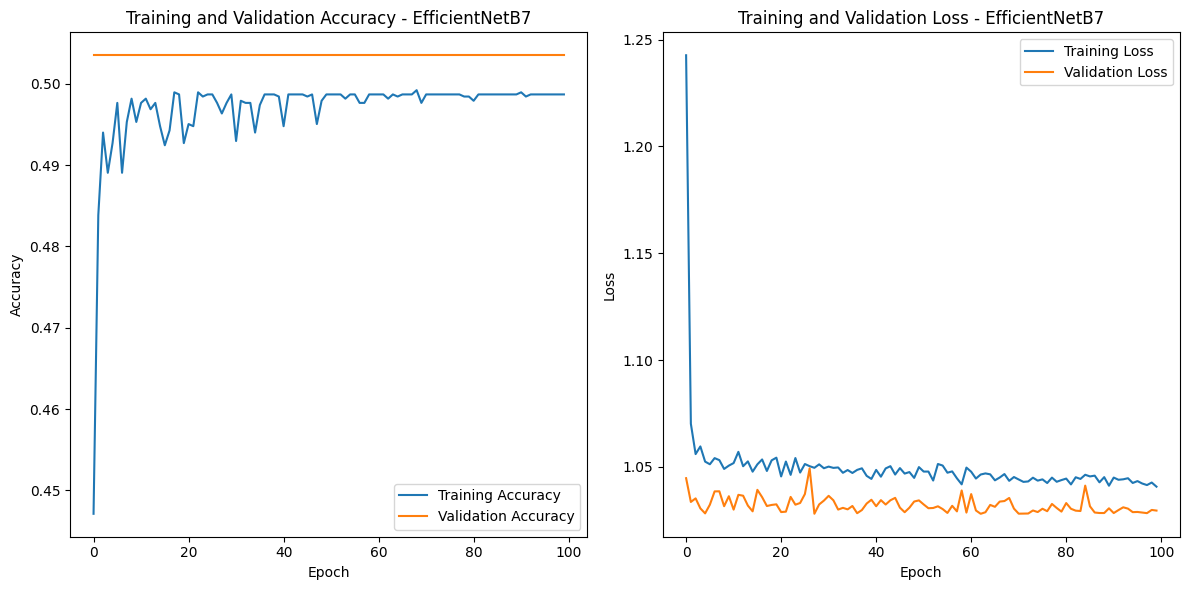

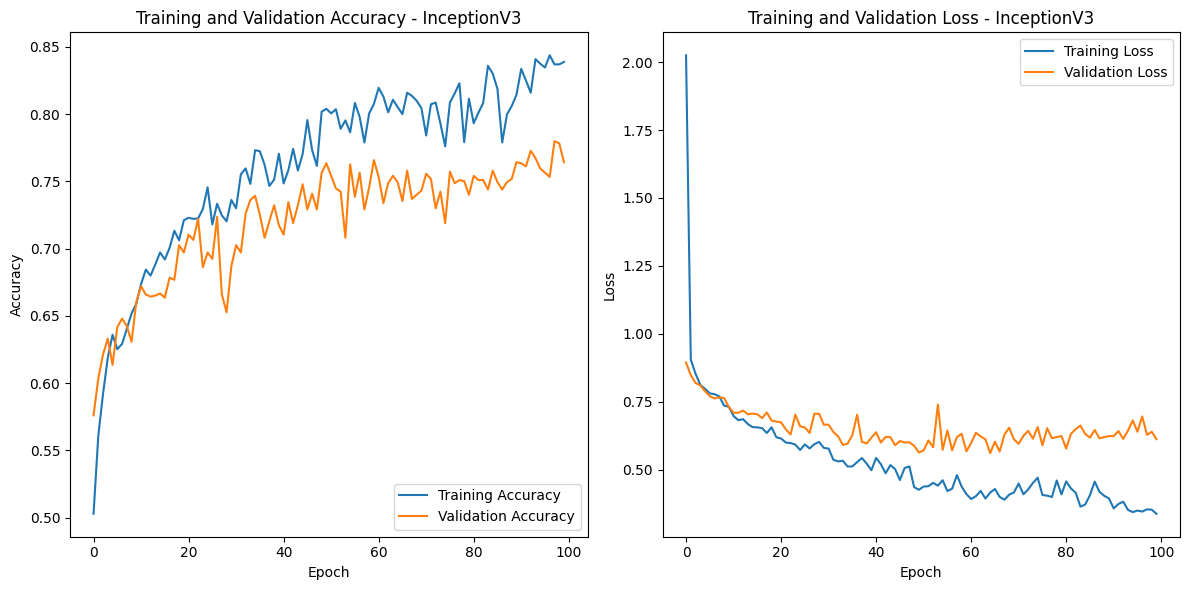

In [30]:
import matplotlib.pyplot as plt

# Iterate through each model's history
for model_name, history in history_dict.items():
    # Extract history metrics
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()


19/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

W0000 00:00:1721123273.482127     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Model: Proposed
ACC: 1.00
SEN: 1.00
SPE: 1.00
AUC: nan




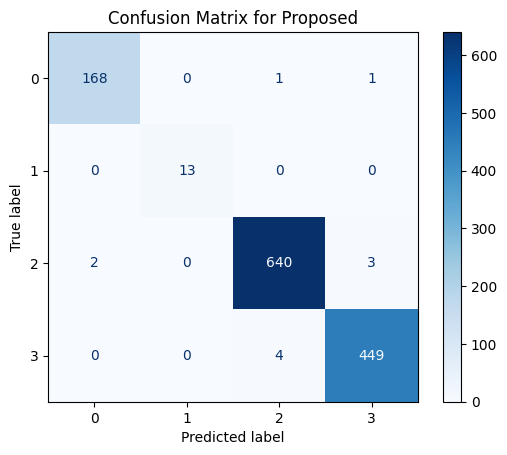

 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

W0000 00:00:1721123294.364431     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step
Model: DenseNet121
ACC: 0.99
SEN: 0.83
SPE: 1.00
AUC: nan




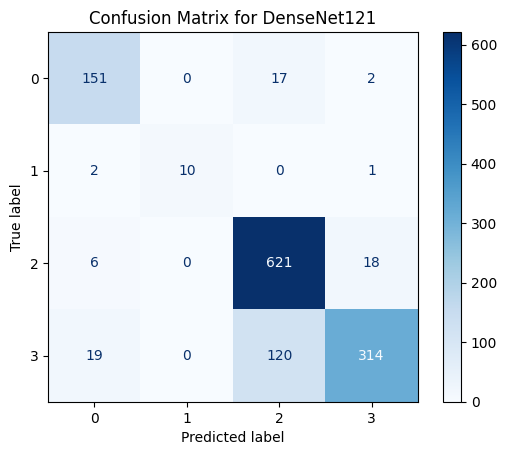

 6/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

W0000 00:00:1721123312.964778     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step
Model: ResNet50
ACC: 0.95
SEN: 0.00
SPE: 1.00
AUC: nan




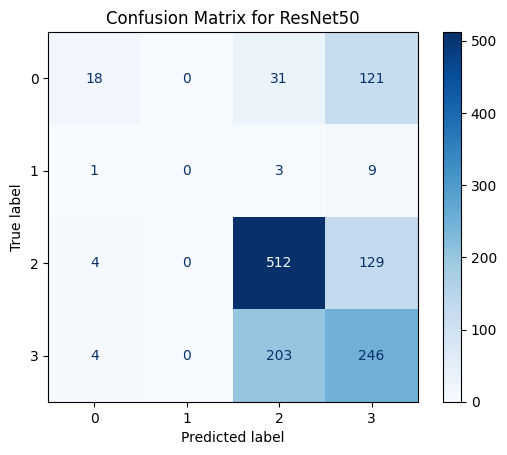

 4/41 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

W0000 00:00:1721123333.457855     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step
Model: VGG16
ACC: 0.99
SEN: 1.00
SPE: 0.99
AUC: nan




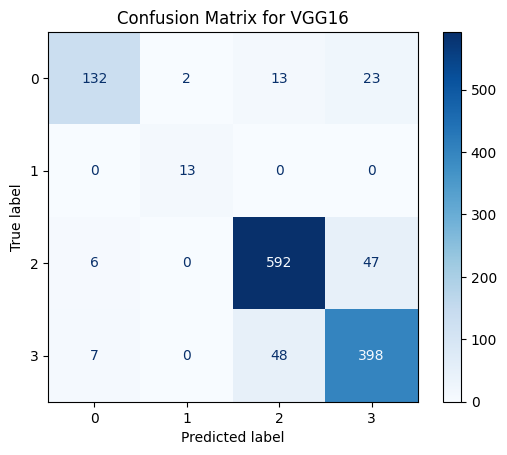

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step  

W0000 00:00:1721123359.766110     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step
Model: EfficientNetB7
ACC: nan
SEN: nan
SPE: nan
AUC: nan




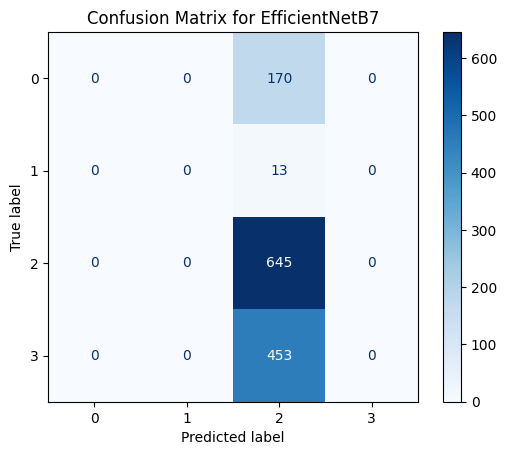

 7/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

W0000 00:00:1721123394.190332     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step
Model: InceptionV3
ACC: 0.99
SEN: 0.67
SPE: 1.00
AUC: nan




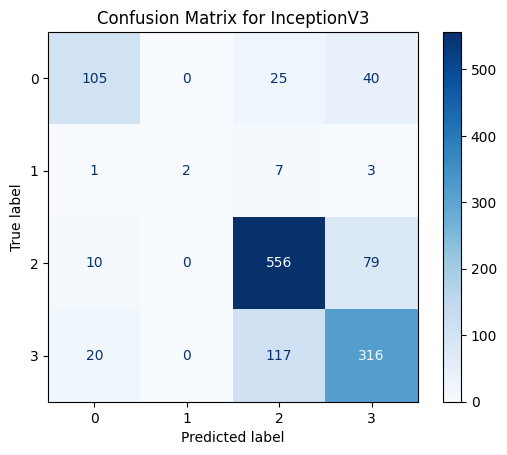

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Function to calculate ACC, SEN, and SPE from confusion matrix
def calculate_metrics(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    ACC = (TN + TP) / (TN + TP + FN + FP) if (TN + TP + FN + FP) > 0 else float('nan')
    SEN = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
    SPE = TN / (TN + FP) if (TN + FP) > 0 else float('nan')
    
    return ACC, SEN, SPE

# Iterate through each model's history
for model_name, model in models.items():
    # Predictions on validation data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
    
    # True labels from validation data
    y_true_labels = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Calculate metrics
    ACC, SEN, SPE = calculate_metrics(cm)
    
    # Compute AUC
    try:
        y_pred_prob = y_pred[:, 1]  # Predicted probabilities for the positive class
        AUC = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    except ValueError:
        AUC = float('nan')  # Handle case where AUC calculation is not possible
    
    # Print metrics
    print(f"Model: {model_name}")
    print(f"ACC: {ACC:.2f}")
    print(f"SEN: {SEN:.2f}")
    print(f"SPE: {SPE:.2f}")
    print(f"AUC: {AUC:.2f}")
    print("\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


In [31]:
# history = model.fit(X_train, y_train, batch_size = 40, validation_data=(X_test, y_test), validation_split = 0.1, epochs = epoch)

In [32]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

In [33]:
# Accuracy_Score = round(acc[len(acc)-1]*100, 2)
# print("The Accuracy for the model is: ", Accuracy_Score, '%')

# Validation_Score = round(val_acc[len(val_acc)-1]*100, 2)
# print("The Validation Accuracy for the model is: ",Validation_Score , "%\n")

# Loss_score = round(loss[len(loss)-1], 2)
# print("The loss for the model is: ", Loss_score)

# Validation_loss = round(val_loss[len(val_loss)-1], 2)
# print("The Validation Loss for the model is: ", Validation_loss)

In [34]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(epoch), acc, label='Training Accuracy')
# plt.plot(range(epoch), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(epoch), loss, label='Training Loss')
# plt.plot(range(epoch), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [35]:
# # Function to build models with pre-trained architectures
# def pretrained_model(base_model, input_shape=(150, 150, 1), num_classes=4):
#     input_tensor = Input(shape=input_shape)
#     x = tf.keras.layers.Concatenate()([input_tensor, input_tensor, input_tensor])  # Convert grayscale to 3 channels
#     base_model = base_model(include_top=False, weights='imagenet', input_tensor=x)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=input_tensor, outputs=predictions)
    
#     for layer in base_model.layers:
#         layer.trainable = False
        
#     optimizer = Adam(learning_rate=0.00001)
#     model.compile(optimizer='adam', loss = CategoricalCrossentropy, metrics=['accuracy'])
#     return model

In [36]:
# # Define models
# models = {
#     'Proposed': proposed_model(),
#     'DenseNet121': pretrained_model(DenseNet121),
#     'ResNet50': pretrained_model(ResNet50),
#     'VGG16': pretrained_model(VGG16),
#     'EfficientNetB7': pretrained_model(EfficientNetB7),
#     'InceptionV3': pretrained_model(InceptionV3)
# }

# # Dictionary to store training history
# history_dict = {}

In [37]:
# # Train each model with the data generator
# for model_name, model in models.items():
#     print(f"Training {model_name} Model : ")
#     history = model.fit(
#         datagen.flow(X_train, y_train, batch_size=40),
#         epochs=100,
# #         callbacks=[early_stopping, reduce_lr, lr_schedule],
#         validation_data=(X_test, y_test),
#         shuffle=True  # Shuffle data for each epoch
#     )
#     history_dict[model_name] = history.history

In [38]:
# # Iterate through each model's history
# for model_name, history in history_dict.items():
#     # Extract history metrics
#     acc = history['accuracy']
#     val_acc = history['val_accuracy']
#     loss = history['loss']
#     val_loss = history['val_loss']
    
#     # Calculate final metrics
#     Accuracy_Score = round(acc[-1] * 100, 2)
#     Validation_Score = round(val_acc[-1] * 100, 2)
#     Loss_score = round(loss[-1], 2)
#     Validation_loss = round(val_loss[-1], 2)
    
#     # Print metrics
#     print(f"Model: {model_name}")
#     print(f"The Accuracy for the model is: {Accuracy_Score}%")
#     print(f"The Validation Accuracy for the model is: {Validation_Score}%")
#     print(f"The Loss for the model is: {Loss_score}")
#     print(f"The Validation Loss for the model is: {Validation_loss}\n")


In [39]:
# import matplotlib.pyplot as plt

# # Iterate through each model's history
# for model_name, history in history_dict.items():
#     # Extract history metrics
#     acc = history['accuracy']
#     val_acc = history['val_accuracy']
#     loss = history['loss']
#     val_loss = history['val_loss']
    
#     # Create a new figure
#     plt.figure(figsize=(12, 6))
    
#     # Plot training and validation accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(range(len(acc)), acc, label='Training Accuracy')
#     plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
#     plt.legend(loc='lower right')
#     plt.title(f'Training and Validation Accuracy - {model_name}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
    
#     # Plot training and validation loss
#     plt.subplot(1, 2, 2)
#     plt.plot(range(len(loss)), loss, label='Training Loss')
#     plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
#     plt.legend(loc='upper right')
#     plt.title(f'Training and Validation Loss - {model_name}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
    
#     plt.tight_layout()
#     plt.show()


In [40]:
# Proposed model
# # def proposed_model(input_shape=X_train.shape[1:], num_classes=4):
# #     model = Sequential()

# #     # First convolutional block
# #     model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', 
# #                      input_shape=input_shape))
# # #     model.add(BatchNormalization())
# #     model.add(MaxPooling2D(pool_size=(2, 2)))
# #     model.add(Dropout(0.25))

# #     # Second convolutional block
# #     model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
# # #     model.add(BatchNormalization())
# #     model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# #     model.add(Dropout(0.25))

# #     # Third convolutional block
# #     model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
# # #     model.add(BatchNormalization())
# #     model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# #     model.add(Dropout(0.3))

# #     # Fourth convolutional block
# #     model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
# # #     model.add(BatchNormalization())
# #     model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# #     model.add(Dropout(0.3))

# #     # Fifth convolutional block
# #     model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'))
# # #     model.add(BatchNormalization())
# #     model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# #     model.add(Dropout(0.3))

# #     # Fully connected layers
# #     model.add(Flatten())
# #     model.add(Dense(512, activation='relu'))
# # #     model.add(LayerNormalization())
# #     model.add(Dropout(0.3))
# #     model.add(Dense(num_classes, activation='softmax'))
    
#     optimizer = Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, loss = CategoricalCrossentropy, metrics=['accuracy'])
#     return model

# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
# # model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# def lr_scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# lr_schedule = LearningRateScheduler(lr_scheduler)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = load_model('path_to_your_model.h5')

# Load and preprocess the image
img_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image (if your model requires it)

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class[0]}')
plt.show()